In [135]:
import numpy as np
from sompy.sompy import SOMFactory
import pandas as pd
import pickle
import torch
from scipy.io import wavfile as wav
import glob
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
print(os.path.split(nb_dir))
home_dir=r'C:\Study\SpeechAcquisitionModel'
print(nb_dir)
if home_dir not in sys.path:
    sys.path.append(home_dir)
from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.speech_classification.pytorch_conv_lstm import LstmNet

('C:\\Study\\SpeechAcquisitionModel', 'src')
C:\Study\SpeechAcquisitionModel\src


In [137]:
data_folder = r"C:\Study\Speech_command_classification\speech_dataset"
data_path = r"C:\Study\Speech_command_classification\speech_dataset\dataset.pd"
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin',
                    'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                    'up', 'wow', 'yes', 'zero']
wanted_words_tanh_transition = ['a_a', 'a_i', 'a_u', 'a_o', 'a_e',
                                'i_a', 'i_i', 'i_u', 'i_o', 'i_e',
                                'u_a', 'u_i', 'u_u', 'u_o', 'u_e',
                                'o_a', 'o_i', 'o_u', 'o_o', 'o_e',
                                'e_a', 'e_i', 'e_u', 'e_o', 'e_e']

wanted_words_combined = wanted_words + wanted_words_tanh_transition
model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.04
}
sr = 22050

In [138]:
preproc = AudioPreprocessorFbank(model_settings['dct_coefficient_count'], winlen=model_settings['winlen'], winstep=model_settings['winstep'])
# wav_read = lambda fname: [1][].reshape(-1,25)
def wav_read(fname):
    sr, w = wav.read(fname)
    # extend to 1 sec
    if len(w) < 22050:
        w = np.concatenate((w, np.zeros(22050 - len(w))))
    return w.reshape(25, -1)


data_iter = SpeechCommandsDataCollector(wav_read,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

In [139]:
n_data_size = 10000
d = data_iter.get_data(n_data_size, 0, 'training')
data = d['x']
labels = d['y']
seq_lengths = d['seq_len']



In [104]:
print(data.shape)


(50000, 25, 882)


In [140]:
ld = list(data)
sx = pd.Series(ld, dtype=np.dtype("object"))
df = pd.DataFrame({'audio': sx})
data=df
data['y'] = labels

In [2]:

data_path = r'C:/Study/SpeechAcquisitionModel/data/raw/Simple_transitions/02_25_2019_03_29_PM_08/02_25_2019_03_29_PM_08.pd'
with open(data_path, 'rb') as f:
    data = pickle.load(f)
print('data is loaded')


data is loaded


In [3]:

# preproc_params = {
#       "nfilt": 26,
#       "winlen": 0.04,
#       "winstep": 0.04,
#       "sample_rate": 22050
#     }
# sr = preproc_params['sample_rate']
# preproc = AudioPreprocessorFbank(**preproc_params)
# print("preproc is initialized")


preproc is initialized


In [141]:

preproc_net_fname = "C:/Study/SpeechAcquisitionModel/models/speech_classification/simple_lstm_03_27_2019_02_36_PM_acc_0.7383.pt"
device='cpu'
preproc_net = torch.load(preproc_net_fname).to(device)
hidden = None
print("preproc net is initialized")


preproc net is initialized


In [ ]:

idx = 0
data_len = data.shape[0]

preproc_list = []
preproc_net_list = []
for idx in range(data_len):
    print(f'\r {idx} out of {data_len}', end="")
    audio = data.iloc[idx]["audio"]
    preprocessed = np.stack([preproc(audio[i, :], sr) for i in range(audio.shape[0])]).squeeze()
    preproc_audio = torch.from_numpy(preprocessed[np.newaxis]).float().to(device)
    hidden = None
    _, hidden, reference = preproc_net(preproc_audio,
                                          seq_lens=np.array([preproc_audio.shape[1]]),
                                          hidden=hidden)
    reference = reference.detach().cpu().numpy().squeeze()

    preproc_list.append(preprocessed)
    preproc_net_list.append(reference)
print()





 8498 out of 10000

In [ ]:
data['preproc'] = preproc_list
data['preproc_net'] = preproc_net_list
data['y'] = labels
with open(data_path, 'wb') as f:
    pickle.dump(data, f)

In [ ]:

preproc_net_data = data['preproc_net'].values

num_frames = preproc_net_data[0].shape[0]
num_features = preproc_net_data[0].shape[1]
print(num_frames)
print(num_features)

labels = data['y'].values
labels = np.repeat(labels, num_frames)

print(labels.shape)

joined_data = np.concatenate(preproc_net_data)
print(joined_data.shape)

names = [str(i) for i in range(num_features)]
joined_data = pd.DataFrame(joined_data)


In [111]:

# create the SOM network and train it. You can experiment with different normalizations and initializations
sm = SOMFactory().build(joined_data.values, normalization = 'var', initialization='pca', mapsize=[100, 100], component_names=names)
sm.train(n_job=5, verbose='debug', train_rough_len=5, train_finetune_len=5)

 Training...
--------------------------------------------------------------
 details: 
      > data len is 1250000 and data dimension is 128
      > map size is 100,100
      > array size in log10 scale is 12.204119982655925
      > number of jobs in parallel: 5
 -------------------------------------------------------------

 pca_linear_initialization took: 4.282000 seconds
 Rough training...
 radius_ini: 13.000000 , radius_final: 3.250000, trainlen: 5

 find_bmu took: 134.393000 seconds
 update_codebook_voronoi took: 1.018000 seconds
 epoch: 1 ---> elapsed time:  136.141000, quantization error: 8.358363

 find_bmu took: 201.060000 seconds
 update_codebook_voronoi took: 1.083000 seconds
 epoch: 2 ---> elapsed time:  202.963000, quantization error: 7.890174

 find_bmu took: 193.520000 seconds
 update_codebook_voronoi took: 0.976000 seconds
 epoch: 3 ---> elapsed time:  195.314000, quantization error: 6.970699

 find_bmu took: 201.414000 seconds
 update_codebook_voronoi took: 1.027000 se

In [9]:
# The quantization error: average distance between each data vector and its BMU.
# The topographic error: the proportion of all data vectors for which first and second BMUs are not adjacent units.
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))


 find_bmu took: 49.172000 seconds
 find_bmu took: 52.797000 seconds


Topographic error = 0.3332853333333333; Quantization error = 0.9535436966847082


In [87]:

print(sm._component_names[0])

# component planes view
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=12)
view2D.show(sm, col_sz=4, which_dim="all", denormalize=True)




['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127']


In [88]:
# U-matrix plot
from sompy.visualization.umatrix import UMatrixView

umat  = UMatrixView(width=10,height=10,title='U-matrix')
umat.show(sm)



KeyboardInterrupt: 

In [12]:
# # do the K-means clustering on the SOM grid, sweep across k = 2 to 20
# from sompy.visualization.hitmap import HitMapView
# K = 20 # stop at this k for SSE sweep
# K_opt = 18 # optimal K already found
# _ = sm.cluster(K)
# hits  = HitMapView(20,20,"Clustering",text_size=12)
# a=hits.show(sm)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [112]:
import matplotlib.pyplot as plt
import random
from collections import defaultdict

labels_unique = list(np.unique(labels))
print(labels_unique)
cmap = plt.get_cmap('plasma')
colors = [cmap(i) for i in np.linspace(0, 1, len(labels_unique))]

d = defaultdict(list)

plt.figure(figsize=(14,14))
for j in np.random.randint(0, 3000, 500):
#     print(j)
#     d[labels[j*25]
    sample = np.array(joined_data.iloc[j*25 :(j+1)*25].values)
    prj = sm.find_bmu(sample)
#     prj_1 = sm.project_data(sample)
#     print(prj_1)
#     bmus_xy = sm.bmu_ind_to_xy(prj_1)

    bmus_xy = sm.bmu_ind_to_xy(prj[0])
    d[labels[j*25]].append(bmus_xy)

    # [sm.bmu_ind_to_xy(p) for p in prj[0].reshape(-1,1)]
#     print(bmus_xy)


# print(x)
# print(y)


 find_bmu took: 0.105000 seconds


[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]


 find_bmu took: 0.102000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu 

 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.104000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu 

 find_bmu took: 0.102000 seconds


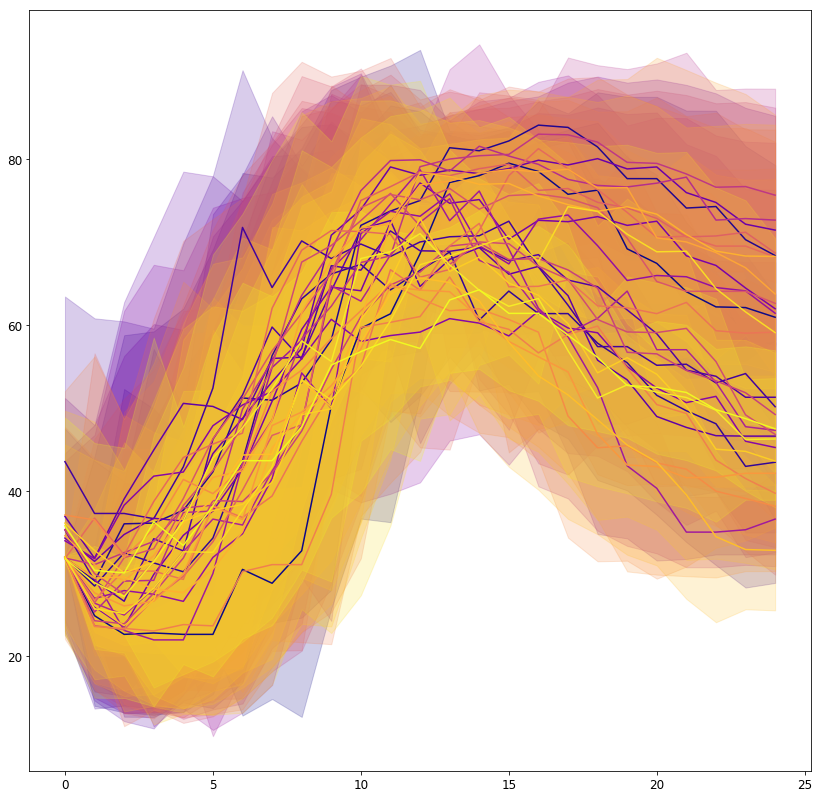

In [113]:
for l in labels_unique:
    if len(d[l]) == 0:
        print(1)
        continue
    xy = np.array(d[l])
    xy_mean = xy.mean(axis=0)
    xy_std = xy.std(axis=0)
    t = np.arange(0, 25, 1)
    plt.plot(t, xy_mean[:, 1], label=l, color=colors[labels_unique.index(l)])
    plt.fill_between(t, xy_mean[:, 1]-xy_std[:,1],  xy_mean[:, 1]+xy_std[:, 1], color=colors[labels_unique.index(l)], alpha=0.2)
# x, y, ind = zip(*bmus_xy)
# plt.plot(x, y, label=labels[j*25], color=colors[labels_unique.index(labels[j*25])], alpha=0.5 )

# # plt.legend()
plt.show()


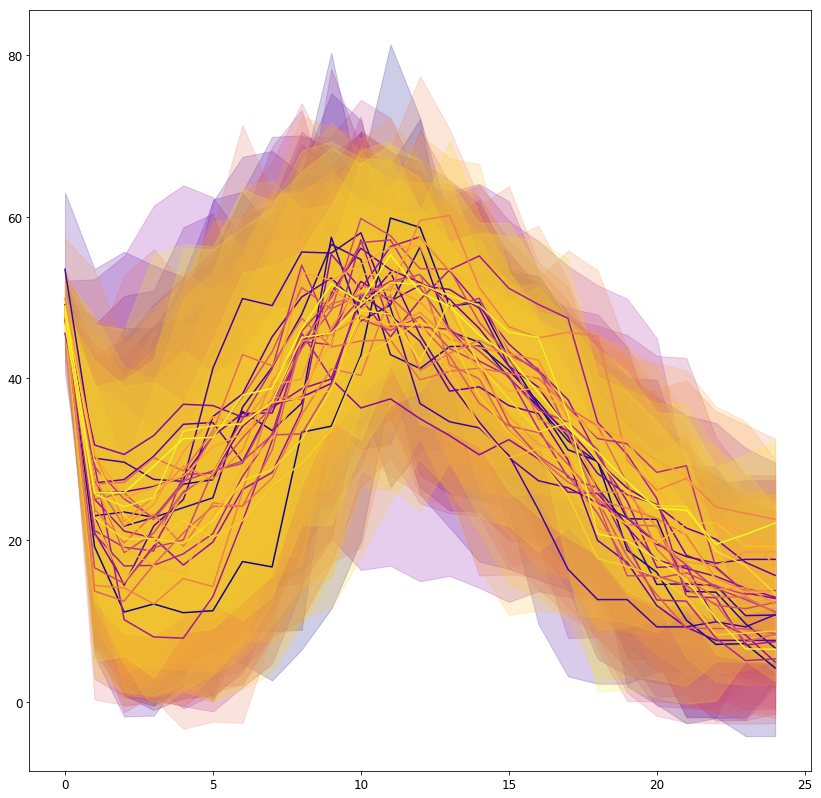

In [114]:
plt.figure(figsize=(14,14))
for l in labels_unique:
    if len(d[l]) == 0:
        print(1)
        continue
    xy = np.array(d[l])
    xy_mean = xy.mean(axis=0)
    xy_std = xy.std(axis=0)
    t = np.arange(0, 25, 1)
    plt.plot(t, xy_mean[:, 0], label=l, color=colors[labels_unique.index(l)])
    plt.fill_between(t, xy_mean[:, 0]-xy_std[:,0],  xy_mean[:, 0]+xy_std[:, 0], color=colors[labels_unique.index(l)], alpha=0.2)
# x, y, ind = zip(*bmus_xy)
# plt.plot(x, y, label=labels[j*25], color=colors[labels_unique.index(labels[j*25])], alpha=0.5 )

# # plt.legend()
plt.show()

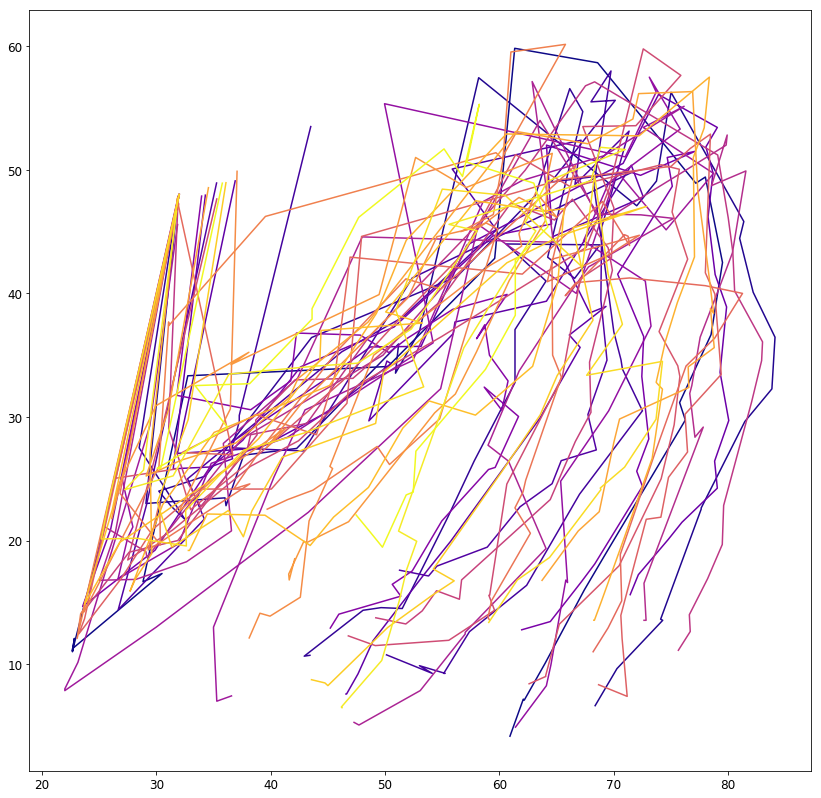

In [115]:
plt.figure(figsize=(14,14))
for l in labels_unique:
    if len(d[l]) == 0:
        print(1)
        continue
    xy = np.array(d[l])
    xy_mean = xy.mean(axis=0)
    xy_std = xy.std(axis=0)
    t = np.arange(0, 25, 1)
    plt.plot(xy_mean[:,1], xy_mean[:, 0], label=l, color=colors[labels_unique.index(l)])
#     plt.fill_between(t, xy_mean[:, 0]-xy_std[:,0],  xy_mean[:, 0]+xy_std[:, 0], color=colors[labels_unique.index(l)], alpha=0.2)
# x, y, ind = zip(*bmus_xy)
# plt.plot(x, y, label=labels[j*25], color=colors[labels_unique.index(labels[j*25])], alpha=0.5 )

# # plt.legend()
plt.show()

<IPython.core.display.Javascript object>


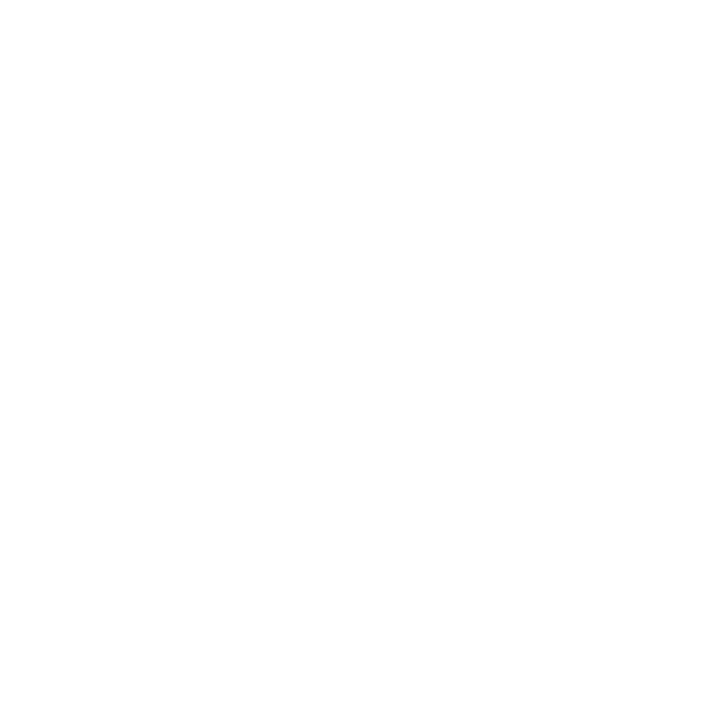

<IPython.core.display.Javascript object>


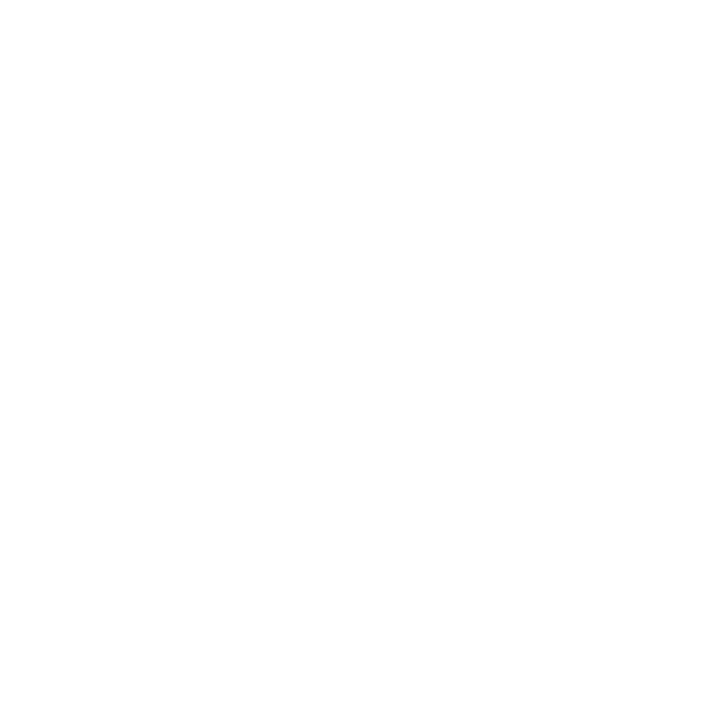

In [127]:
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
%matplotlib notebook
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
for l in labels_unique:
    if len(d[l]) == 0:
        print(1)
        continue
    xy = np.array(d[l])
    xy_mean = xy.mean(axis=0)
    xy_std = xy.std(axis=0)
    t = np.arange(0, 25, 1)
    ax.plot3D(xy_mean[:,1], xy_mean[:, 0], t, label=l, color=colors[labels_unique.index(l)])
#     plt.fill_between(t, xy_mean[:, 0]-xy_std[:,0],  xy_mean[:, 0]+xy_std[:, 0], color=colors[labels_unique.index(l)], alpha=0.2)
# x, y, ind = zip(*bmus_xy)
# plt.plot(x, y, label=labels[j*25], color=colors[labels_unique.index(labels[j*25])], alpha=0.5 )

# # plt.legend()
plt.show()

In [20]:
t = np.arange(0, 25, 1)
print(t)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


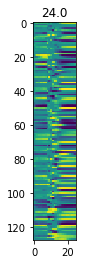

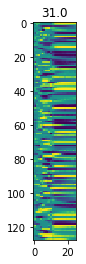

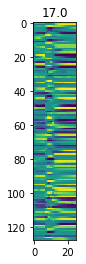

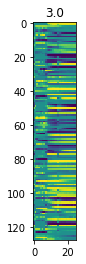

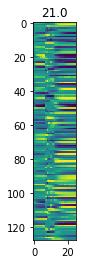

In [134]:
%matplotlib inline
plt.figure()
for j in np.random.randint(0, 3000, 5):
#     print(j)
#     d[labels[j*25]
    sample = np.array(joined_data.iloc[j*25 :(j+1)*25].values)
    plt.imshow(sample.T)
    plt.title(labels[j*25])
    plt.show()